In [1]:
import platform

In [3]:
platform.system()

'Linux'

In [1]:
import pandas as pd
import numpy as numpy
from importlib import reload
from tqdm import tqdm_notebook as tqdm
import time

import pdaactconn as pc
from trialexplorer import AACTStudySet

import matplotlib.pyplot
%matplotlib inline

/Users/akhazan/.virtualenvs/notebooks_venv/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
conn = pc.AACTConnection(source=pc.AACTConnection.REMOTE)
ss = AACTStudySet.AACTStudySet(conn=conn, tqdm_handler=tqdm)
ss.add_constraint("study_type = 'Interventional'")
ss.show_constraints()
ss.load_studies()

WHERE 1=1 
    AND (study_type = 'Interventional')

252253 studies loaded!


#### Adding dimensions to filter dataset and add data related to results and outcomes

In [194]:
ss.add_dimensions([
    'countries', 
    'conditions', 
    'browse_conditions',
    'keywords', 
    'pending_results', 
    'design_outcomes', 
    'designs', 
    'result_groups',
    'milestones', 
    'baseline_counts', 
    'baseline_measurements', 
    'outcomes', 
    'outcome_analyses', 
    'outcome_analysis_groups', 
    'outcome_counts',
    'outcome_measurements', 
    'browse_interventions', 
    'interventions', 
    'intervention_other_names'
])

Successfuly added these 19 dimensions: ['countries', 'conditions', 'browse_conditions', 'keywords', 'pending_results', 'design_outcomes', 'designs', 'result_groups', 'milestones', 'baseline_counts', 'baseline_measurements', 'outcomes', 'outcome_analyses', 'outcome_analysis_groups', 'outcome_counts', 'outcome_measurements', 'browse_interventions', 'interventions', 'intervention_other_names']
Failed to add these 0 dimensions: []


In [4]:
ss.refresh_dim_data()

Syncing the temp table temp_cur_studies in 505 chunks x 500 records each

Creating index on the temp table
 - Loading dimension countries
 -- Loading raw data
 -- Sorting index
 - Loading dimension conditions
 -- Loading raw data
 -- Sorting index
 - Loading dimension browse_conditions
 -- Loading raw data
 -- Sorting index
 - Loading dimension keywords
 -- Loading raw data
 -- Sorting index
 - Loading dimension pending_results
 -- Loading raw data
 -- Sorting index
 - Loading dimension design_outcomes
 -- Loading raw data
 -- Sorting index
 - Loading dimension designs
 -- Loading raw data
 -- Sorting index
 - Loading dimension result_groups
 -- Loading raw data
 -- Sorting index
 - Loading dimension milestones
 -- Loading raw data
 -- Sorting index
 - Loading dimension baseline_counts
 -- Loading raw data
 -- Sorting index
 - Loading dimension baseline_measurements
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcomes
 -- Loading raw data
 -- Sorting index
 - Loading di

In [5]:
countries = ss.dimensions['countries'].data.add_prefix('country_')

#### Count of studies per country, one study can be associated with multiple countries

In [6]:
countries.reset_index().groupby(['country_name']).agg({'country_id':'count'}).sort_values(
    by='country_id', ascending=False).head()

,country_id
country_name,
United States,108607
Canada,19306
France,18495
Germany,16483
United Kingdom,15397


#### Count of countries per study

In [195]:
countries.reset_index().groupby(['nct_id']).agg({'country_name':'nunique'}).sort_values(
    by='country_name', ascending=False).reset_index().groupby(['country_name']).agg({'nct_id':'count'}).sort_values(
    by='nct_id', ascending=False).head()

,nct_id
country_name,
1,203181
2,8778
3,3273
4,2203
5,1757


#### Count of studies with each keyword, one study can be associated with multiple keywords

In [196]:
keywords = ss.dimensions['keywords'].data.add_prefix('keyword_')
keywords['keyword_cancer_related'] = keywords['keyword_downcase_name'].apply(lambda x:'cancer' in x)

keywords.reset_index().groupby(['keyword_downcase_name']).agg({'nct_id':'count'}).sort_values(
    by='nct_id', ascending=False).head()

AttributeError: 'NoneType' object has no attribute 'add_prefix'

#### Count of all studies related to cancer by keyword, broken down by keywords used

In [10]:
keywords[keywords.keyword_downcase_name.str.contains('cancer')].reset_index().groupby(
    ['keyword_downcase_name']).agg({'nct_id':'count'}).sort_values(by='nct_id', ascending=False).head()

,nct_id
keyword_downcase_name,
breast cancer,1867
cancer,1785
prostate cancer,948
lung cancer,637
colorectal cancer,572


#### Count of all studies, related to cancer by keyword or not

In [11]:
keywords.reset_index().groupby(['keyword_cancer_related']).agg({'nct_id':'nunique'})

,nct_id
keyword_cancer_related,
False,165035
True,16526


#### Count of studies submitted per year

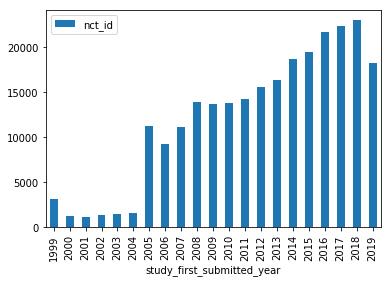

In [193]:
ss.studies['study_first_submitted_year'] = pd.to_datetime(ss.studies['study_first_submitted_date']).dt.year
ss.studies.reset_index().groupby('study_first_submitted_year').agg({'nct_id':'count'}).plot(kind='bar')

#### Count of studies by result dates, completion dates and last known status

In [13]:
ss.studies['results_first_submitted_date_is_null'] = ss.studies['results_first_submitted_date'].isnull()
ss.studies['results_first_submitted_qc_date_is_null'] = ss.studies['results_first_submitted_qc_date'].isnull()
ss.studies['results_first_posted_date_is_null'] = ss.studies['results_first_posted_date'].isnull()
ss.studies['completion_date_is_null'] = ss.studies['completion_date'].isnull()

ss.studies.reset_index().groupby([
    'last_known_status', 'results_first_submitted_qc_date_is_null', 
    'results_first_submitted_date_is_null', 'results_first_posted_date_is_null', 
    'completion_date_is_null']).agg({'nct_id':'count'})

nct_id
last_known_status       results_first_submitted_qc_date_is_null results_first_submitted_date_is_null results_first_posted_date_is_null completion_date_is_null        
Active, not recruiting  False                                   False                                False                             False                        31
                                                                                                                                       True                         15
                        True                                    True                                 True                              False                      4236
                                                                                                                                       True                       1075
Enrolling by invitation True                                    True                                 True                              False                       776
                                                                                                                                       True                         87
Not yet recruiting      True                                    True                                 True                              False                      3734
                                                                                                                                       True                        662
Recruiting              True                                    True                                 True                              False                     11517
                                                                                                                                       True                       2032

#### Interventional studies related to cancer by keyword

In [162]:
df = ss.studies.merge(
    keywords[keywords['keyword_downcase_name'].str.contains('cancer')].reset_index().groupby(['nct_id'])
    .agg({'keyword_id':'count'}), left_index=True, right_index=True, how='inner')

#### Count of interventional cancer studies by result dates, completion dates and last known status

In [163]:
df.reset_index().groupby([
    'last_known_status', 'results_first_submitted_qc_date_is_null', 
    'results_first_submitted_date_is_null', 'results_first_posted_date_is_null', 
    'completion_date_is_null']).agg({'nct_id':'count'})

nct_id
last_known_status       results_first_submitted_qc_date_is_null results_first_submitted_date_is_null results_first_posted_date_is_null completion_date_is_null        
Active, not recruiting  False                                   False                                False                             False                         7
                                                                                                                                       True                          1
                        True                                    True                                 True                              False                       259
                                                                                                                                       True                        322
Enrolling by invitation True                                    True                                 True                              False                        35
                                                                                                                                       True                          4
Not yet recruiting      True                                    True                                 True                              False                       105
                                                                                                                                       True                         23
Recruiting              True                                    True                                 True                              False                       668
                                                                                                                                       True                        224

#### Count of result groups and studies by result group type

In [164]:

df = df.merge(ss.dimensions['result_groups'].data.add_prefix('result_group_'), 
    left_index=True, right_index=True, how='left')

df['result_group_result_type'] = df['result_group_result_type'].fillna('None')

df.reset_index().groupby(['result_group_result_type']).agg({'nct_id':['count', 'nunique']})

nct_id        
                          count nunique
result_group_result_type               
Baseline                   6701    2672
None                      13854   13854
Outcome                   35237    2672
Participant Flow           5492    2672
Reported Event             5434    2670

#### Number of result groups per study

In [165]:
df['number_of_groups'] = df['number_of_groups'].fillna('Unknown')
df.reset_index().groupby(['results_first_posted_date_is_null', 'number_of_groups']).agg({'nct_id':'count'})

,,nct_id
results_first_posted_date_is_null,number_of_groups,
False,Unknown,52864
True,Unknown,13854


#### Number of result group id's per study and study type, different from above

In [166]:
df[df.result_group_id.notnull()].reset_index().groupby(['result_group_result_type', 'nct_id']).agg(
    {'result_group_id':'count'}).sort_values(by='result_group_id', ascending=False).head()

result_group_id
result_group_result_type nct_id                      
Outcome                  NCT01347866              355
                         NCT01449370              346
                         NCT01026402              288
                         NCT00982865              280
                         NCT00141297              263

#### Total study result groups

In [167]:
df[df.result_group_id.notnull()].shape

(52864, 74)

#### Outcome analysis groups

Identifies the comparison groups that were involved with each outcome analysis

In [168]:
outcome_analysis_groups = ss.dimensions['outcome_analysis_groups'].data.add_prefix(
    'outcome_analysis_group_')

outcome_analysis_groups.shape

(309051, 2)

#### Joining outcome analysis groups 

In [169]:

df = df[df.result_group_id.notnull()].reset_index().set_index(['nct_id', 'result_group_id']).merge(
    outcome_analysis_groups.reset_index().set_index(['nct_id', 'result_group_id']),
    left_index=True, right_index=True, how='left')
df.shape

(56832, 76)

#### Outcome analyses

Results of scientifically appropriate statistical analyses performed on primary and 
secondary study outcomes. Includes results for treatment effect estimates, 
confidence intervals and othe rmeasures of dispersion, and p-values.

In [170]:
outcome_analyses = ss.dimensions['outcome_analyses'].data.add_prefix('outcome_analysis_')
outcome_analyses.head()

outcome_analysis_id  \
nct_id      outcome_id                        
NCT00000378 4572247                 2511203   
NCT00000392 4572185                 2511190   
NCT00000620 4572249                 2511204   
            4572250                 2511205   
            4572251                 2511206   

                       outcome_analysis_non_inferiority_type  \
nct_id      outcome_id                                         
NCT00000378 4572247                     Superiority or Other   
NCT00000392 4572185                     Superiority or Other   
NCT00000620 4572249                     Superiority or Other   
            4572250                     Superiority or Other   
            4572251                     Superiority or Other   

                       outcome_analysis_non_inferiority_description  \
nct_id      outcome_id                                                
NCT00000378 4572247                                                   
NCT00000392 4572185                                                   
NCT00000620 4572249                                                   
            4572250                                                   
            4572251                                                   

                       outcome_analysis_param_type  \
nct_id      outcome_id                               
NCT00000378 4572247                                  
NCT00000392 4572185                                  
NCT00000620 4572249              Hazard Ratio (HR)   
            4572250              Hazard Ratio (HR)   
            4572251              Hazard Ratio (HR)   

                        outcome_analysis_param_value  \
nct_id      outcome_id                                 
NCT00000378 4572247                              NaN   
NCT00000392 4572185                              NaN   
NCT00000620 4572249                             0.94   
            4572250                             0.92   
            4572251                             0.59   

                       outcome_analysis_dispersion_type  \
nct_id      outcome_id                                    
NCT00000378 4572247                                       
NCT00000392 4572185                                       
NCT00000620 4572249                                       
            4572250                                       
            4572251                                       

                        outcome_analysis_dispersion_value  \
nct_id      outcome_id                                      
NCT00000378 4572247                                   NaN   
NCT00000392 4572185                                   NaN   
NCT00000620 4572249                                   NaN   
            4572250                                   NaN   
            4572251                                   NaN   

                       outcome_analysis_p_value_modifier  \
nct_id      outcome_id                                     
NCT00000378 4572247                                    <   
NCT00000392 4572185                                 None   
NCT00000620 4572249                                 None   
            4572250                                 None   
            4572251                                 None   

                        outcome_analysis_p_value outcome_analysis_ci_n_sides  \
nct_id      outcome_id                                                         
NCT00000378 4572247                         0.05                               
NCT00000392 4572185                         0.18                               
NCT00000620 4572249                         0.30                     2-Sided   
            4572250                         0.32                     2-Sided   
            4572251                         0.01                     2-Sided   

                        outcome_analysis_ci_percent  \
nct_id      outcome_id                                
NCT00000378 4572247                      

#### Joining outcome analyses

In [171]:

df = df.reset_index().set_index(['nct_id', 'outcome_analysis_id']).merge(
    outcome_analyses.reset_index().set_index(['nct_id', 'outcome_analysis_id']),
    left_index=True, right_index=True, how='left')
df.shape

(56832, 96)

#### Outcomes

Descriptions of outcomes, or observation that were measured to determine patterns
of diseases or traits, or associations with exposures, risk factors, or treatment. 
Includes information such as time frame, population and units. 
(Specific measurement results are stored in the Outcome_Measurements table.)

In [172]:
outcomes = ss.dimensions['outcomes'].data.add_prefix('outcome_')
outcomes.head()

,outcome_id,outcome_outcome_type,outcome_title,outcome_description,outcome_time_frame,outcome_population,outcome_anticipated_posting_date,outcome_anticipated_posting_month_year,outcome_units,outcome_units_analyzed,outcome_dispersion_type,outcome_param_type
nct_id,,,,,,,,,,,,
NCT00000125,4572276,Primary,Incidence of Primary Open-Angle Glaucoma in Hy...,Comparison of the cumulative proportion of par...,"5 yrs (OHTS I, June 2002) and 13.0 yrs (comple...",1636 ocular hypertensive participants were ran...,None,,percent of participants,,,Number
NCT00000134,4572275,Primary,Morbidity,"To determine the best therapeutic regimen, usi...","Patients will be seen at baseline, monthly for...",,None,,participants,,,Number
NCT00000135,4572274,Primary,Mortality Rate,to evaluate the efficacy of an intravenous hum...,All patients enrolled were followed for a 17 m...,,None,,deaths per person-year,,,Number
NCT00000136,4572273,Primary,Mortality,,All patients enrolled will be followed until a...,,None,,participants,,,Number
NCT00000142,4572272,Primary,Survival,,All patients enrolled will be followed until a...,,None,,participants,,,Number


#### Joining outcomes

In [173]:
df = df.reset_index().set_index(['nct_id', 'outcome_id']).merge(
    outcomes.reset_index().set_index(['nct_id', 'outcome_id']), left_index=True, right_index=True, how='left')

df.shape

(56832, 107)

#### Outcome counts

Sample size included in analysis for each outcome for each study group; 
usually participants but can represent other units of measure such as eyes 'lesions', etc.

In [174]:
outcome_counts = ss.dimensions['outcome_counts'].data.add_prefix('outcome_count_')
outcome_counts.head()

outcome_count_id  \
nct_id      result_group_id outcome_id                     
NCT00000125 15120265        4572276             10780426   
            15120266        4572276             10780427   
NCT00000134 15120254        4572275             10780423   
            15120255        4572275             10780424   
            15120256        4572275             10780425   

                                       outcome_count_ctgov_group_code  \
nct_id      result_group_id outcome_id                                  
NCT00000125 15120265        4572276                                O2   
            15120266        4572276                                O1   
NCT00000134 15120254        4572275                                O3   
            15120255        4572275                                O2   
            15120256        4572275                                O1   

                                       outcome_count_scope  \
nct_id      result_group_id outcome_id                       
NCT00000125 15120265        4572276                Measure   
            15120266        4572276                Measure   
NCT00000134 15120254        4572275                Measure   
            15120255        4572275                Measure   
            15120256        4572275                Measure   

                                       outcome_count_units  \
nct_id      result_group_id outcome_id                       
NCT00000125 15120265        4572276           Participants   
            15120266        4572276           Participants   
NCT00000134 15120254        4572275           Participants   
            15120255        4572275           Participants   
            15120256        4572275           Participants   

                                        outcome_count_count  
nct_id      result_group_id outcome_id                       
NCT00000125 15120265        4572276                     817  
            15120266        4572276                     819  
NCT00000134 15120254        4572275                      93  
            15120255        4572275                      93  
            15120256        4572275                      88

#### Joining outcome counts

In [175]:
df = df.reset_index().set_index(['nct_id', 'result_group_id', 'outcome_id']).merge(
    outcome_counts, left_index=True, right_index=True, how='left')

df.shape

(56909, 111)

#### Outcome measurements

Summary data for primary and secondary outcome measures for each study group. 
Includes parameter estimates and measures of dispersion/precision.

In [176]:
outcome_measurements = ss.dimensions['outcome_measurements'].data.add_prefix('outcome_measurement_')
outcome_measurements.head()

outcome_measurement_id  \
nct_id      result_group_id outcome_id                           
NCT00000125 15120265        4572276                   34193878   
                            4572276                   34193880   
            15120266        4572276                   34193879   
                            4572276                   34193881   
NCT00000134 15120254        4572275                   34193875   

                                       outcome_measurement_ctgov_group_code  \
nct_id      result_group_id outcome_id                                        
NCT00000125 15120265        4572276                                      O2   
                            4572276                                      O2   
            15120266        4572276                                      O1   
                            4572276                                      O1   
NCT00000134 15120254        4572275                                      O3   

                                                       outcome_measurement_classification  \
nct_id      result_group_id outcome_id                                                      
NCT00000125 15120265        4572276     Incidence of glaucoma 13 yr (OHTS II, March 2009)   
                            4572276     Incidence of glaucoma at 5 yr (OHTS I, June 2002)   
            15120266        4572276     Incidence of glaucoma 13 yr (OHTS II, March 2009)   
                            4572276     Incidence of glaucoma at 5 yr (OHTS I, June 2002)   
NCT00000134 15120254        4572275                                                         

                                       outcome_measurement_category  \
nct_id      result_group_id outcome_id                                
NCT00000125 15120265        4572276                                   
                            4572276                                   
            15120266        4572276                                   
                            4572276                                   
NCT00000134 15120254        4572275                                   

                                                                outcome_measurement_title  \
nct_id      result_group_id outcome_id                                                      
NCT00000125 15120265        4572276     Incidence of Primary Open-Angle Glaucoma in Hy...   
                            4572276     Incidence of Primary Open-Angle Glaucoma in Hy...   
            15120266        4572276     Incidence of Primary Open-Angle Glaucoma in Hy...   
                            4572276     Incidence of Primary Open-Angle Glaucoma in Hy...   
NCT00000134 15120254        4572275                                             Morbidity   

                                                          outcome_measurement_description  \
nct_id      result_group_id outcome_id                                                      
NCT00000125 15120265        4572276     Comparison of the cumulative proportion of par...   
                            4572276     Comparison of the cumulative proportion of par...   
            15120266        4572276     Comparison of the cumulative proportion of par...   
                            4572276     Comparison of the cumulative proportion of par...   
NCT00000134 15120254        4572275     To determine the best therapeutic regimen, usi...   

                                       outcome_measurement_units  \
nct_id      result_group_id outcome_id                             
NCT00000125 15120265        4572276      percent of participants   
                            4572276      percent of participants   
            15120266        4572276      percent of participants   
                            4572276      percent of participants   
NCT00000134 15120254        4572275                 participants   

                                       outcome_measurement_param_type  \
nct_id      result_

#### Joining outcome measurements

In [177]:
df = df.merge(outcome_measurements, left_index=True, right_index=True, how='left')
df.shape

(229873, 127)

In [178]:
df.columns[:100]

Index(['outcome_analysis_id', 'nlm_download_date_description',
       'study_first_submitted_date', 'results_first_submitted_date',
       'disposition_first_submitted_date', 'last_update_submitted_date',
       'study_first_submitted_qc_date', 'study_first_posted_date',
       'study_first_posted_date_type', 'results_first_submitted_qc_date',
       'results_first_posted_date', 'results_first_posted_date_type',
       'disposition_first_submitted_qc_date', 'disposition_first_posted_date',
       'disposition_first_posted_date_type', 'last_update_submitted_qc_date',
       'last_update_posted_date', 'last_update_posted_date_type',
       'start_month_year', 'start_date_type', 'start_date',
       'verification_month_year', 'verification_date', 'completion_month_year',
       'completion_date_type', 'completion_date',
       'primary_completion_month_year', 'primary_completion_date_type',
       'primary_completion_date', 'target_duration', 'study_type', 'acronym',
       'baseline_popu

#### Distinct studies and results groups by outcome measurement title

In [191]:
df['outcome_measurement_title'] = df['outcome_measurement_title'].fillna('Unknown')
df.reset_index().groupby(['outcome_measurement_title']).agg(
    {'nct_id':'nunique', 'result_group_id':'nunique'}).sort_values(
    by='nct_id', ascending=False).head()

,nct_id,result_group_id
outcome_measurement_title,,
Unknown,2672,47549
Overall Survival,95,205
Overall Survival (OS),72,157
Progression Free Survival (PFS),28,60
Progression-Free Survival (PFS),28,60
